# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, csv, shutil
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from datetime import date
from envs.env_gridsearch import kellycriterion
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import DummyVecEnv
from utils.read2df import read2df
from utils.rlmetrics import get_return, get_metrics
from utils.clearlogs import clear_logs
from envs.env_rl_restrict import PairTradingEnv
from params import *

from stable_baselines3 import PPO, A2C, DQN
import quantstats as qs

folder_path = f"result/rl-restrict-thres"
os.makedirs(folder_path, exist_ok=True)

Load data from `preliminaries.ipynb`

In [2]:
import pickle

with open('result/cointncorr.pickle', 'rb') as pk:
    data = pickle.load(pk)

dfs = read2df(symbols=data[0], freqs={data[1]: freqs[data[1]]})

df0 = dfs[0][dfs[0]['tic']==data[0][0]].reset_index(drop=True)
df1 = dfs[0][dfs[0]['tic']==data[0][1]].reset_index(drop=True)

# Because we want to calculate profit based on BTC. Hence the price need to be changed.
df0 = df0[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df0['close'] = df0['close'].apply(lambda x: 1/x)

df1 = df1[['time', 'close', 'volume', 'tic', 'itvl', 'datetime']]
df1['close'] = df1['close'].apply(lambda x: 1/x)

Set data before `trade_data` as training data, after `trade_data` is trade_data

In [3]:
train0 = df0[df0['datetime'] < trade_date]
train1 = df1[df1['datetime'] < trade_date]

test0 = df0[df0['datetime'] >= trade_date]
test1 = df1[df1['datetime'] >= trade_date]

max_train_len = len(train0)-900-1
print(f"The length of our training data: {len(train0)}")

The length of our training data: 1591841


## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [4]:
from stable_baselines3.common.env_checker import check_env
# > UserWarning: The action space is not based off a numpy array. Typically this means it's either a Dict or Tuple space. This type of action space is currently not supported by Stable Baselines 3. You should try to flatten the action using a wrapper.
# Baseline 3 does not support Dict/Tuple action spaces....only Box Discrete MultiDiscrete MultiBinary
# Is there another way to achieve the same functionality?

env = PairTradingEnv(train0, train1)
check_env(env)

## Do an experimental run with randomly generated actions

In [5]:
# env = PairTradingEnv(train0, train1, tc=0.002, verbose=1, model=f"{folder_path}/networth_experiment.csv")
# obs, _ = env.reset()

# print(f"observation_space: {env.observation_space}")
# print(f"action_space: {env.action_space}")
# print(f"action_space.sample: {env.action_space.sample()}")

# n_steps = 20

# for step in range(n_steps):
#     obs, reward, terminated, truncated, info = env.step(action=env.action_space.sample())
#     done = terminated or truncated
#     env.render()
#     if done:
#         break

## Models from stable_baselines3

Delete existing tensorboard logs

In [6]:
log_path = f"logs/restrict_thres/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

Deleted: logs/restrict_thres/PPO_1


Train with training data

In [7]:
'''PPO'''

env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_ppo.csv")

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size =10000, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len/20)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [8]:
# '''A2C'''

# env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_a2c.csv")

# model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
# model_a2c.learn(total_timesteps=max_train_len/10)
# model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [9]:
# '''DQN'''

# env = PairTradingEnv(train0, train1, tc=0.00, model=f"{folder_path}/networth_dqn.csv")

# model_dqn = DQN("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
# model_dqn.learn(total_timesteps=max_train_len/10)
# model_dqn.save(f"{folder_path}/dqn_pairtrading")

## Use the model on Test data

In [10]:
# # del model_ppo, model_a2c, model_dqn

# model_ppo = PPO.load(f"{folder_path}/ppo_pairtrading")
# model_a2c = A2C.load(f"{folder_path}/a2c_pairtrading")
# model_dqn = DQN.load(f"{folder_path}/dqn_pairtrading")

In [11]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

env = PairTradingEnv(test0, test1, tc=0.00, verbose=0, model=f"{folder_path}/networth_ppo.csv")
obs, _ = env.reset()

while True:
    action, _states = model_ppo.predict(obs)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    env.render()
    if terminated:
        print("Test Finished!")
        break
    elif truncated:
        print("bankrupted!")
        break

Test Finished!


In [12]:
# try:
#     os.remove(f"{folder_path}/networth_a2c.csv")
# except OSError:
#     pass

# env = PairTradingEnv(test0, test1, tc=0.00, model=f"{folder_path}/networth_a2c.csv")
# obs, _ = env.reset()

# while True:
#     action, _states = model_a2c.predict(obs)
#     observation, reward, terminated, truncated, info = env.step(action)
#     done = terminated or truncated
#     env.render()
#     if terminated:
#         print("Test Finished!")
#         break
#     elif truncated:
#         print("bankrupted!")
#         break

In [13]:
# try:
#     os.remove(f"{folder_path}/networth_dqn.csv")
# except OSError:
#     pass

# env = PairTradingEnv(test0, test1, tc=0.00, verbose=0, model=f"{folder_path}/networth_dqn.csv")
# obs, _ = env.reset()

# while True:
#     action, _states = model_dqn.predict(obs)
#     observation, reward, terminated, truncated, info = env.step(action)
#     done = terminated or truncated
#     env.render()
#     if terminated:
#         print("Test Finished!")
#         break
#     elif truncated:
#         print("bankrupted!")
#         break

### Analyze with Quanstats

In [14]:
os.remove(f"{folder_path}/networth_experiment.csv") if os.path.exists(f"{folder_path}/networth_experiment.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

The ending capital of networth_ppo.csv is ['2023-11-30 23:59:59.999000', '0.9926821932206948']
The best model is networth_ppo.csv


In [15]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

len(best_return)

Compound annual growth rate: -2%
Total orders count: 219416
Total long action: 77170
Total short action: 80194
Won orders count: 77170
Lost orders count: 80194
Win/Loss order ratio: 0.9622914432501185
Max win: values      1.013488
action      2.000000
zscore      0.000000
position    2.000000
price0      0.000700
price1      0.000800
pnl         0.010816
returns     0.001305
dtype: float64
Max Loss: values      0.988368
action      0.000000
zscore      0.000000
position    0.000000
price0      0.000500
price1      0.000578
pnl        -0.010586
returns    -0.010824
dtype: float64
Avg order pnl: 3.348282319792911e-08
Avg order pnl won: 4.334111474011716e-07
Avg order pnl lost: -6.625573288543657e-07
Avg long order pnl: 1.9434875055703165e-08
Avg short order pnl: 1.0284929662503413e-07


219416

# Some graphs

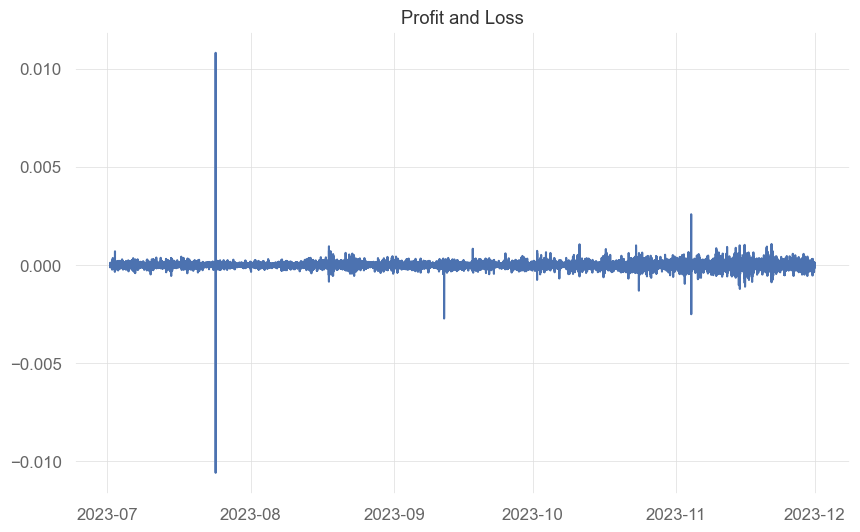

In [16]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['pnl'])

plt.show()

In [17]:
# fig, (ax1, ax2) = plt.subplots(2, 1)

# ax1.plot(best_return['return'])

                           Strategy
-------------------------  ----------
Start Period               2023-07-01
End Period                 2023-11-30
Risk-Free Rate             0.0%
Time in Market             72.0%

Cumulative Return          -0.73%
CAGR﹪                     -1.21%

Sharpe                     -0.01
Prob. Sharpe Ratio         40.82%
Smart Sharpe               -0.01
Sortino                    -0.01
Smart Sortino              -0.01
Sortino/√2                 -0.01
Smart Sortino/√2           -0.01
Omega                      1.0

Max Drawdown               -2.33%
Longest DD Days            108
Volatility (ann.)          0.1%
Calmar                     -0.52
Skew                       -0.39
Kurtosis                   7608.67

Expected Daily %           -0.0%
Expected Monthly %         -0.15%
Expected Yearly %          -0.73%
Kelly Criterion            -0.12%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.01%
Expected Shortfall (cVaR)  -0.01%

Max Consecutive W

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-08-15,2023-11-27,2023-11-30,108,-2.330534,-2.197234
2,2023-07-09,2023-07-24,2023-08-04,26,-1.424499,-0.790193
3,2023-07-03,2023-07-04,2023-07-06,4,-0.440548,-0.431296
4,2023-08-12,2023-08-13,2023-08-14,2,-0.199441,-0.177045
5,2023-07-07,2023-07-07,2023-07-09,3,-0.192796,-0.180754


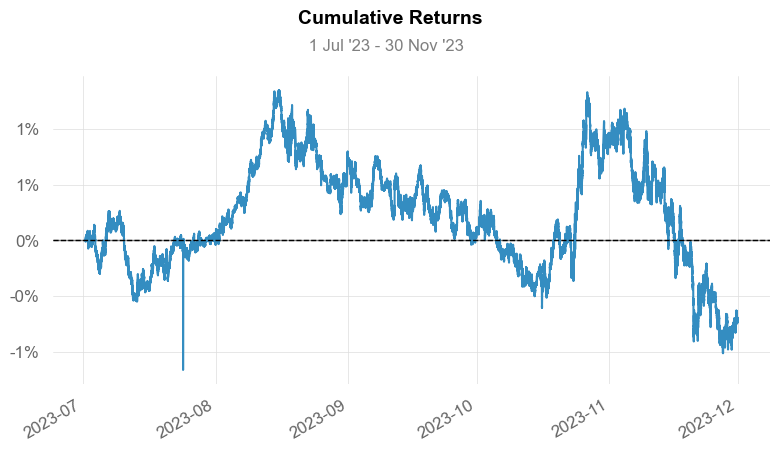

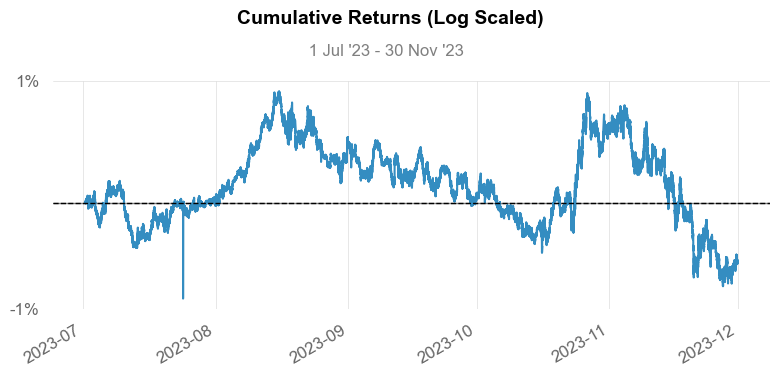

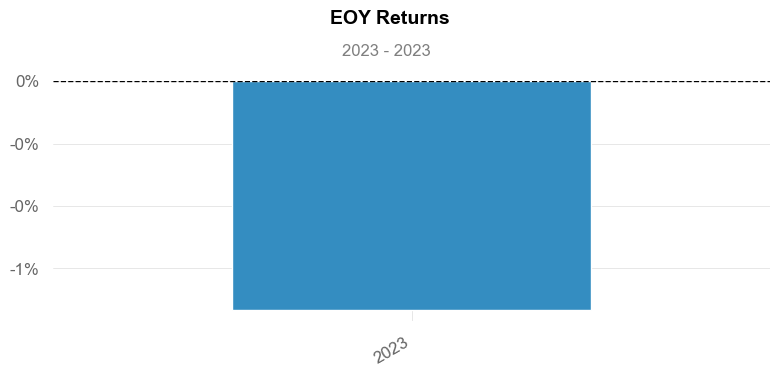

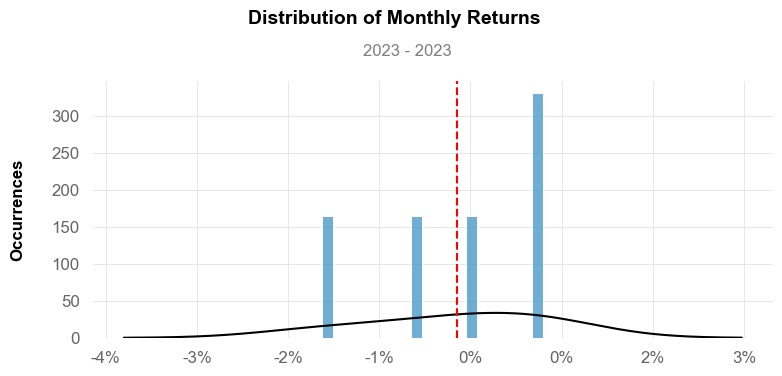

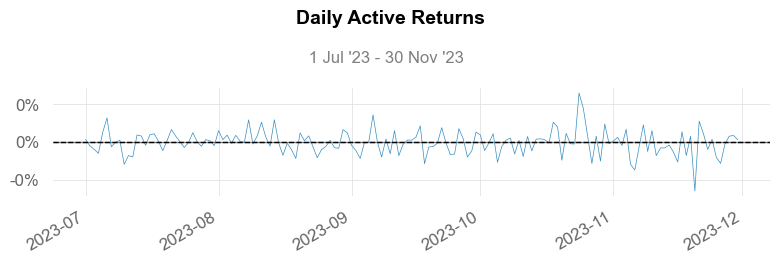

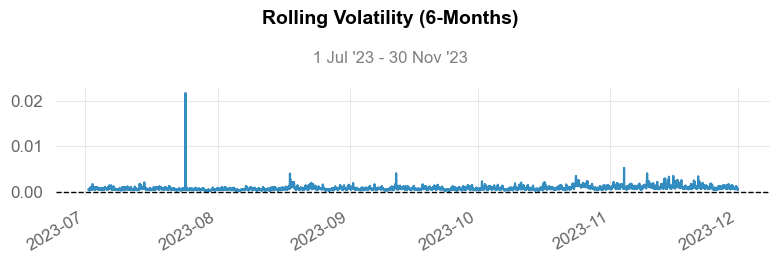

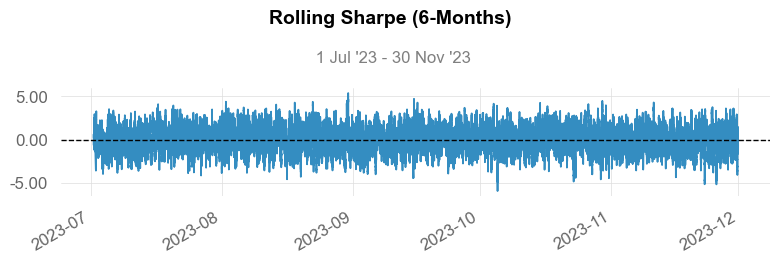

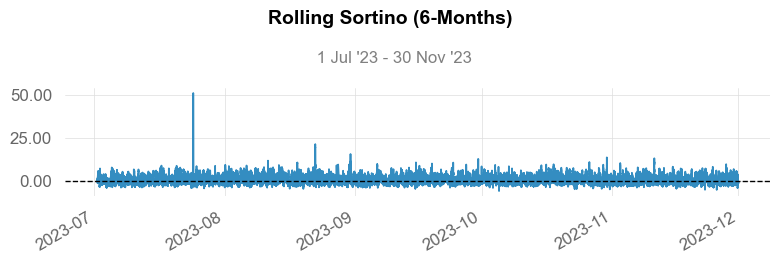

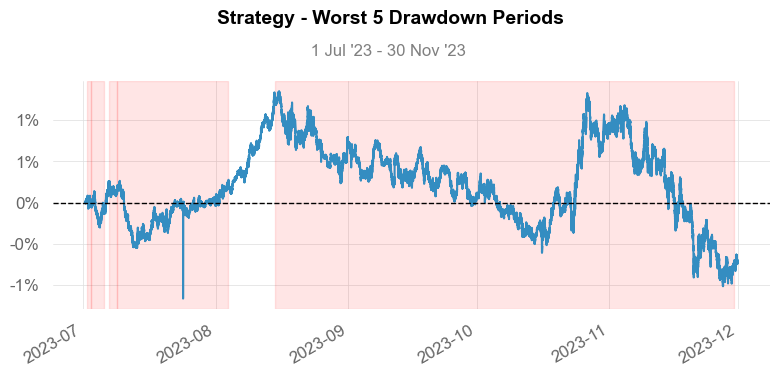

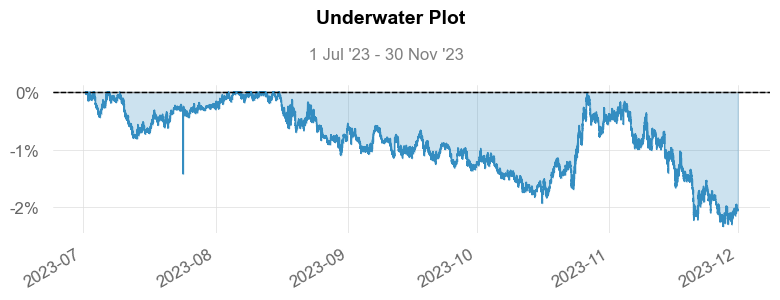

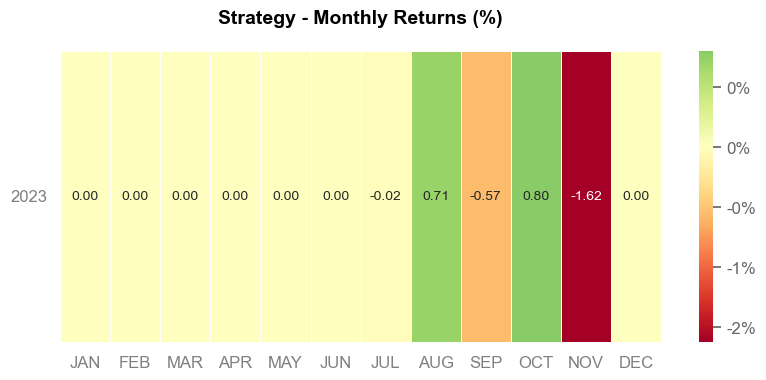

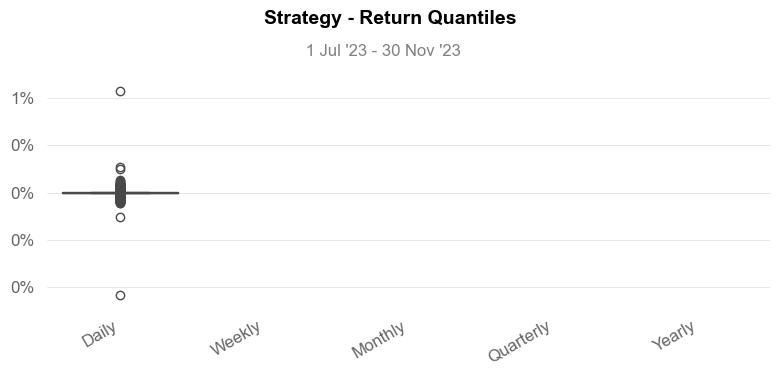

In [18]:
qs.reports.full(best_return['returns'])